In [ ]:
# # Análisis de Interpretabilidad Definitivo: Importancia de ROIs
# 
# **Objetivo**: Identificar y rankear los ROIs más influyentes para la clasificación CN vs AD, utilizando los artefactos guardados durante el entrenamiento para máxima reproducibilidad.

# ## Paso 1: Cargar Artefactos del Fold 1
# 
# Cargamos todos los ficheros generados por `serentipia8.py` para el primer fold.
import pathlib
from pathlib import Path
import torch
import torch.nn as nn
import joblib
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from captum.attr import IntegratedGradients
from typing import Tuple, Union, List
from tqdm import tqdm

# --- Definición de la Clase ConvolutionalVAE ---
# Usamos la definición exacta del script de entrenamiento
class ConvolutionalVAE(nn.Module):
    def __init__(
        self, input_channels: int = 6, latent_dim: int = 128, image_size: int = 131,
        final_activation: str = "tanh", intermediate_fc_dim_config: Union[int, str] = "0",
        dropout_rate: float = 0.2, use_layernorm_fc: bool = False,
        num_conv_layers_encoder: int = 4, decoder_type: str = "convtranspose", num_groups: int = 8
    ) -> None:
        super().__init__()
        if num_conv_layers_encoder not in {3, 4}: raise ValueError("num_conv_layers_encoder must be 3 or 4.")
        if decoder_type not in {"upsample_conv", "convtranspose"}: raise ValueError("decoder_type must be 'upsample_conv' or 'convtranspose'.")
        self.latent_dim = latent_dim; self.num_groups = num_groups; encoder_layers: List[nn.Module] = []; curr_ch = input_channels
        base_conv_ch = [max(16, input_channels * 2), max(32, input_channels * 4), max(64, input_channels * 8), max(128, input_channels * 16)]
        conv_ch_enc = [min(c, 256) for c in base_conv_ch][:num_conv_layers_encoder]
        kernels = [7, 5, 5, 3][:num_conv_layers_encoder]; paddings = [1, 1, 1, 1][:num_conv_layers_encoder]; strides = [2, 2, 2, 2][:num_conv_layers_encoder]
        spatial_dims = [image_size]; dim = image_size
        for k, p, s, ch_out in zip(kernels, paddings, strides, conv_ch_enc):
            encoder_layers += [
                nn.Conv2d(curr_ch, ch_out, kernel_size=k, stride=s, padding=p),
                nn.GELU(), nn.GroupNorm(self.num_groups, ch_out), nn.Dropout2d(p=dropout_rate),
            ]; curr_ch = ch_out; dim = ((dim + 2 * p - k) // s) + 1; spatial_dims.append(dim)
        self.encoder_conv = nn.Sequential(*encoder_layers)
        self.final_conv_ch = curr_ch; self.final_spatial_dim = dim; flat_size = curr_ch * dim * dim
        self.intermediate_fc_dim = self._resolve_intermediate_fc(intermediate_fc_dim_config, flat_size)
        if self.intermediate_fc_dim:
            fc_layers = [nn.Linear(flat_size, self.intermediate_fc_dim)]
            if use_layernorm_fc: fc_layers.append(nn.LayerNorm(self.intermediate_fc_dim))
            fc_layers += [nn.GELU(), nn.BatchNorm1d(self.intermediate_fc_dim), nn.Dropout(p=dropout_rate)]
            self.encoder_fc_intermediate = nn.Sequential(*fc_layers); mu_logvar_in = self.intermediate_fc_dim
        else: self.encoder_fc_intermediate = nn.Identity(); mu_logvar_in = flat_size
        self.fc_mu = nn.Linear(mu_logvar_in, latent_dim); self.fc_logvar = nn.Linear(mu_logvar_in, latent_dim)
        if self.intermediate_fc_dim:
            dec_fc_layers = [nn.Linear(latent_dim, self.intermediate_fc_dim)]
            if use_layernorm_fc: dec_fc_layers.append(nn.LayerNorm(self.intermediate_fc_dim))
            dec_fc_layers += [nn.GELU(), nn.BatchNorm1d(self.intermediate_fc_dim), nn.Dropout(p=dropout_rate)]
            self.decoder_fc_intermediate = nn.Sequential(*dec_fc_layers); dec_fc_out = self.intermediate_fc_dim
        else: self.decoder_fc_intermediate = nn.Identity(); dec_fc_out = latent_dim
        self.decoder_fc_to_conv = nn.Linear(dec_fc_out, flat_size); decoder_layers: List[nn.Module] = []
        curr_ch_dec = self.final_conv_ch; target_conv_t_channels = conv_ch_enc[-2::-1] + [input_channels]
        decoder_kernels = kernels[::-1]; decoder_paddings = paddings[::-1]; decoder_strides = strides[::-1]; output_paddings: List[int] = []
        tmp_dim = self.final_spatial_dim
        for i in range(len(decoder_kernels)):
            k, s, p = decoder_kernels[i], decoder_strides[i], decoder_paddings[i]
            target_dim = spatial_dims[len(decoder_kernels) - 1 - i]; op = target_dim - ((tmp_dim - 1) * s - 2 * p + k)
            output_paddings.append(max(0, min(s - 1, op))); tmp_dim = (tmp_dim - 1) * s - 2 * p + k + op
        for i, ch_out in enumerate(target_conv_t_channels):
            decoder_layers += [nn.ConvTranspose2d(curr_ch_dec, ch_out, kernel_size=decoder_kernels[i], stride=decoder_strides[i], padding=decoder_paddings[i], output_padding=output_paddings[i]), nn.GELU() if i < len(target_conv_t_channels) - 1 else nn.Identity()]
            if i < len(target_conv_t_channels) - 1: decoder_layers += [nn.GroupNorm(self.num_groups, ch_out), nn.Dropout2d(p=dropout_rate)]
            curr_ch_dec = ch_out
        if final_activation == "sigmoid": decoder_layers.append(nn.Sigmoid())
        elif final_activation == "tanh": decoder_layers.append(nn.Tanh())
        self.decoder_conv = nn.Sequential(*decoder_layers)
    def _resolve_intermediate_fc(self, cfg: Union[int, str], flat_size: int) -> int:
        if cfg == "0" or cfg == 0: return 0
        if isinstance(cfg, str):
            cfg = cfg.lower()
            if cfg == "half": return flat_size // 2
            if cfg == "quarter": return flat_size // 4
            try: return int(cfg)
            except ValueError: return 0
        return int(cfg)
    def encode(self, x: torch.Tensor) -> Tuple[torch.Tensor, torch.Tensor]:
        h = self.encoder_conv(x); h = h.view(h.size(0), -1); h = self.encoder_fc_intermediate(h)
        return self.fc_mu(h), self.fc_logvar(h)
    def forward(self, x: torch.Tensor) -> Tuple[torch.Tensor, torch.Tensor, torch.Tensor, torch.Tensor]:
        mu, logvar = self.encode(x); z = self.reparameterize(mu, logvar); recon_x = self.decode(z)
        if recon_x.shape != x.shape: recon_x = nn.functional.interpolate(recon_x, size=(x.shape[2], x.shape[3]), mode="bilinear", align_corners=False)
        return recon_x, mu, logvar, z

def apply_normalization_params(data_tensor_subset: np.ndarray, norm_params_per_channel_list: list) -> np.ndarray:
    num_subjects, num_selected_channels, num_rois, _ = data_tensor_subset.shape; normalized_tensor_subset = data_tensor_subset.copy(); off_diag_mask = ~np.eye(num_rois, dtype=bool)
    for c_idx_selected in range(num_selected_channels):
        params = norm_params_per_channel_list[c_idx_selected]; mode = params.get('mode', 'zscore_offdiag')
        if params.get('no_scale', False): continue
        current_channel_data = data_tensor_subset[:, c_idx_selected, :, :]; scaled_channel_data_subset = current_channel_data.copy()
        if off_diag_mask.any():
            if mode == 'zscore_offdiag':
                if params['std'] > 1e-9: scaled_channel_data_subset[:, off_diag_mask] = (current_channel_data[:, off_diag_mask] - params['mean']) / params['std']
        normalized_tensor_subset[:, c_idx_selected, :, :] = scaled_channel_data_subset
    return normalized_tensor_subset

# --- Configuración de Rutas y Parámetros ---
OUTPUT_DIR = Path('/home/diego/Escritorio/limpio/resultados_12_inter')
FOLD_DIR = OUTPUT_DIR / 'fold_1'
TENSOR_PATH = '/home/diego/Escritorio/limpio/AAL3_dynamicROIs_fmri_tensor_NeuroEnhanced_v6.5.17_AAL3_131ROIs_OMST_GCE_Signed_GrangerLag1_ChNorm_ROIreorderedYeo17_ParallelTuned/GLOBAL_TENSOR_from_AAL3_dynamicROIs_fmri_tensor_NeuroEnhanced_v6.5.17_AAL3_131ROIs_OMST_GCE_Signed_GrangerLag1_ChNorm_ROIreorderedYeo17_ParallelTuned.npz'
METADATA_PATH = '/home/diego/Escritorio/limpio/SubjectsData_AAL3_procesado.csv'
MAPPING_PATH = './aal3_131_to_yeo17_mapping.csv' # Para agrupar por red
CHANNELS_TO_USE = [1, 2, 5]; METADATA_FEATURES = ['Age', 'Sex']
VAE_PARAMS = {'input_channels': len(CHANNELS_TO_USE), 'latent_dim': 512, 'image_size': 131, 'final_activation': 'tanh', 'intermediate_fc_dim_config': 'quarter', 'dropout_rate': 0.2, 'use_layernorm_fc': False, 'num_conv_layers_encoder': 4, 'decoder_type': 'convtranspose', 'num_groups': 8}

# --- Carga de artefactos generados por serentipia8.py ---
device = torch.device("cuda" if torch.cuda.is_available() else "cpu"); print(f"Usando dispositivo: {device}")
vae_model = ConvolutionalVAE(**VAE_PARAMS); vae_model.load_state_dict(torch.load(FOLD_DIR / "vae_model_fold_1.pt", map_location=device)); vae_model.to(device); vae_model.eval(); print("Modelo VAE cargado.")
clf_pipeline = joblib.load(FOLD_DIR / "classifier_logreg_pipeline_fold_1.joblib"); print("Pipeline de Clasificador cargado.")
norm_params_fold1 = joblib.load(FOLD_DIR / "vae_norm_params.joblib"); print("Parámetros de Normalización del VAE cargados.")
test_indices = np.load(FOLD_DIR / "test_indices.npy"); print(f"Índices de Test del Fold cargados ({len(test_indices)} sujetos).")
roi_order = joblib.load(OUTPUT_DIR / "roi_order_131.joblib"); print(f"Orden de ROIs cargado ({len(roi_order)} ROIs).")
yeo_mapping_df = pd.read_csv(MAPPING_PATH)

# Cargar datos completos
global_tensor_data = np.load(TENSOR_PATH)['global_tensor_data']
metadata_df = pd.read_csv(METADATA_PATH); metadata_df['SubjectID'] = metadata_df['SubjectID'].astype(str).str.strip(); subject_ids_tensor = np.load(TENSOR_PATH)['subject_ids'].astype(str); tensor_df = pd.DataFrame({'SubjectID': subject_ids_tensor, 'tensor_idx': np.arange(len(subject_ids_tensor))}); metadata_df_full = pd.merge(tensor_df, metadata_df, on='SubjectID', how='left')
cn_ad_df = metadata_df_full[metadata_df_full['ResearchGroup_Mapped'].isin(['CN', 'AD'])].copy()
test_subject_df = cn_ad_df.iloc[test_indices]


# ## Paso 2: Modelo Wrapper y Cálculo de Saliencia
class FullPipelineWrapper(torch.nn.Module):
    def __init__(self, vae, clf_pipeline, device):
        super().__init__(); self.vae = vae; scaler = clf_pipeline.named_steps['scaler']; logreg = clf_pipeline.named_steps['model']
        self.scaler_mean = torch.tensor(scaler.mean_, dtype=torch.float32, device=device); self.scaler_std = torch.tensor(scaler.scale_, dtype=torch.float32, device=device)
        self.logreg_weights = torch.tensor(logreg.coef_, dtype=torch.float32, device=device); self.logreg_bias = torch.tensor(logreg.intercept_, dtype=torch.float32, device=device)
    def forward(self, input_tensor, metadata_tensor):
        mu, _ = self.vae.encode(input_tensor); combined_features = torch.cat([mu, metadata_tensor], dim=1)
        scaled_features = (combined_features - self.scaler_mean) / self.scaler_std
        logits = torch.matmul(scaled_features, self.logreg_weights.T) + self.logreg_bias
        return torch.sigmoid(logits)
full_model = FullPipelineWrapper(vae_model, clf_pipeline, device).to(device)

all_roi_scores = []
for _, subject_row in tqdm(test_subject_df.iterrows(), total=len(test_subject_df), desc="Calculando saliencia de sujetos"):
    subject_tensor_original = global_tensor_data[subject_row['tensor_idx'], :, :, :][CHANNELS_TO_USE, :, :][np.newaxis, ...]; subject_tensor_norm = apply_normalization_params(subject_tensor_original, norm_params_fold1)
    input_tensor = torch.from_numpy(subject_tensor_norm).float().to(device)
    age_val = float(subject_row['Age']); sex_val = 1.0 if subject_row['Sex'] == 'F' else 0.0
    metadata_np = np.array([[age_val, sex_val]], dtype=np.float32); metadata_tensor = torch.from_numpy(metadata_np).to(device)
    ig = IntegratedGradients(full_model)
    attributions, _ = ig.attribute(inputs=input_tensor, additional_forward_args=(metadata_tensor,), target=0, return_convergence_delta=True)
    saliency_map = attributions.cpu().detach().numpy().squeeze()
    roi_scores = np.abs(saliency_map).sum(axis=(0, 2))
    all_roi_scores.append(roi_scores)
global_roi_saliency = np.mean(all_roi_scores, axis=0)
print(f"\nSaliencia global de ROIs calculada promediando {len(all_roi_scores)} sujetos.")


# ## Paso 3: Ranking y Visualización de ROIs
roi_ranking_df = pd.DataFrame({
    'ROI_Name': roi_order, # Usamos la lista de nombres en el orden correcto
    'Saliency_Score': global_roi_saliency
})
# Añadimos la información de la red para el plot
roi_ranking_df = pd.merge(roi_ranking_df, yeo_mapping_df[['AAL3_Name', 'Yeo17_Network']], left_on='ROI_Name', right_on='AAL3_Name', how='left').drop(columns=['AAL3_Name'])
roi_ranking_df = roi_ranking_df.sort_values(by='Saliency_Score', ascending=False).reset_index(drop=True)

print("\n--- RANKING DE IMPORTANCIA POR ROI INDIVIDUAL (GLOBAL) ---")
roi_ranking_df.head(25)




Usando dispositivo: cuda


/tmp/ipykernel_3333767/1686338411.py:129: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  vae_model = ConvolutionalVAE(**VAE_PARAMS); vae_model.load_state_dict(torch.load(FOLD

Modelo VAE cargado.
Pipeline de Clasificador cargado.
Parámetros de Normalización del VAE cargados.
Índices de Test del Fold cargados (37 sujetos).
Orden de ROIs cargado (131 ROIs).


Calculando saliencia de sujetos: 100%|██████████| 37/37 [00:00<00:00, 46.45it/s]


Saliencia global de ROIs calculada promediando 37 sujetos.

--- RANKING DE IMPORTANCIA POR ROI INDIVIDUAL (GLOBAL) ---


,ROI_Name,Saliency_Score,Yeo17_Network
0,Vermis_7,0.339025,NaN
1,Heschl_R,0.334613,NaN
2,Putamen_R,0.283399,NaN
3,OFClat_R,0.240831,NaN
4,Parietal_Sup_R,0.228081,NaN
5,Postcentral_R,0.226533,NaN
6,Occipital_Mid_R,0.221951,NaN
7,Temporal_Inf_R,0.219674,NaN
8,Lingual_R,0.218030,NaN
9,Occipital_Inf_R,0.214909,NaN


/tmp/ipykernel_3333767/2003794228.py:4: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.barplot(x='Saliency_Score', y='ROI_Name', data=top_25_rois, hue='Yeo17_Network', dodge=False, palette='tab20', ax=ax)
/tmp/ipykernel_3333767/2003794228.py:8: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend(title='Red Funcional (Yeo17)'); plt.tight_layout()



Gráfico con el ranking de los 25 ROIs más importantes guardado.


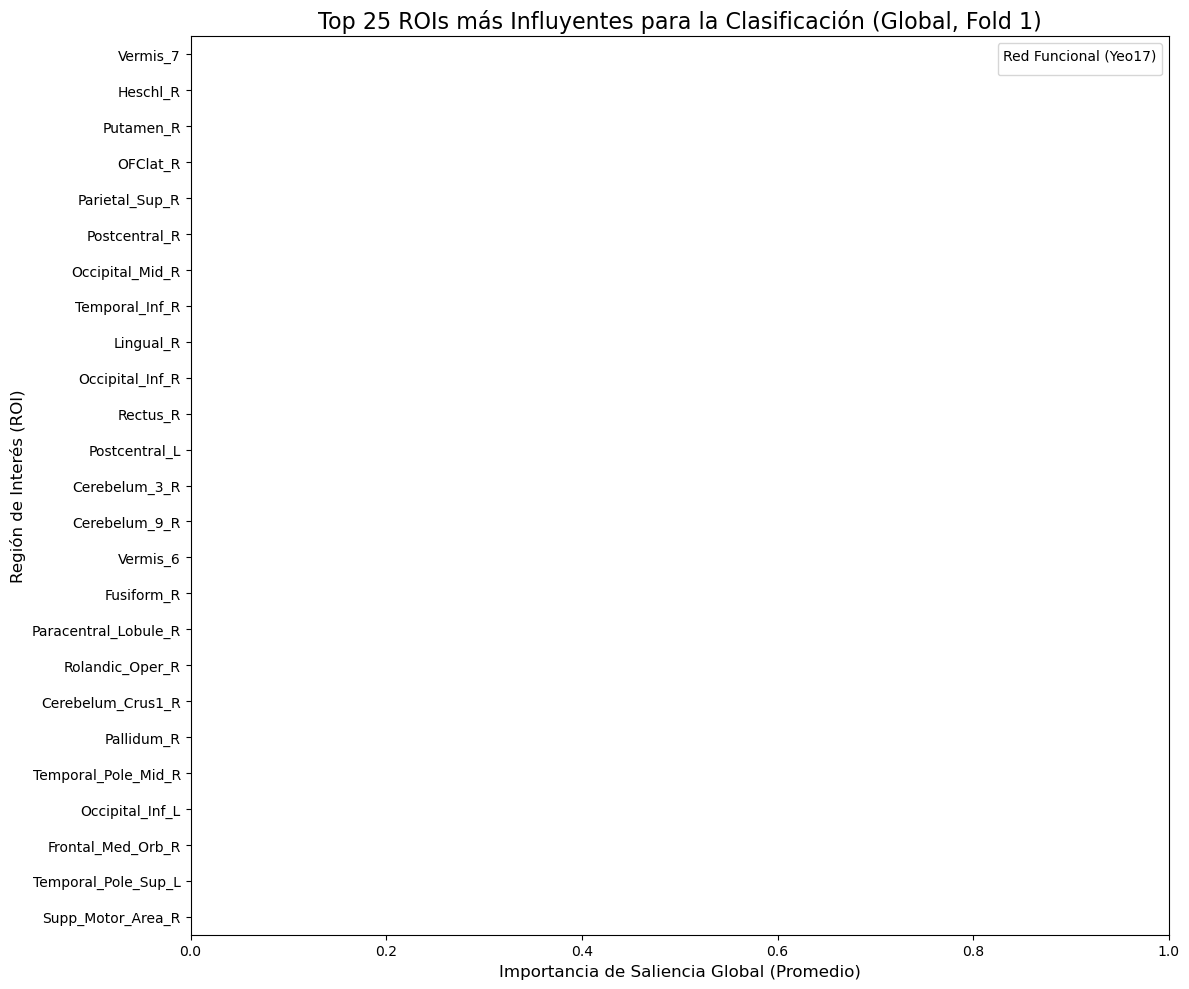

In [2]:
# --- Visualización ---
top_25_rois = roi_ranking_df.head(25)
fig, ax = plt.subplots(figsize=(12, 10))
sns.barplot(x='Saliency_Score', y='ROI_Name', data=top_25_rois, hue='Yeo17_Network', dodge=False, palette='tab20', ax=ax)
ax.set_title('Top 25 ROIs más Influyentes para la Clasificación (Global, Fold 1)', fontsize=16)
ax.set_xlabel('Importancia de Saliencia Global (Promedio)', fontsize=12)
ax.set_ylabel('Región de Interés (ROI)', fontsize=12)
ax.legend(title='Red Funcional (Yeo17)'); plt.tight_layout()
plt.savefig(OUTPUT_DIR / "top_25_roi_ranking_global.png")
print("\nGráfico con el ranking de los 25 ROIs más importantes guardado.")
plt.show()